# Logistic Regression Credit Risk Model Pipeline

1.  Logistic Regression Model

2.  Logistic Regression Model Performance:
-   **ROC_AUC**
-   **Balanced Accuracy** (Balanced Accuracy= 0.5 * (Sensitivity + Specificity))
-   **Confusion Matrix** (Precision Recall)
-   **Log Loss**

2.  Logistic Regression Model Calibration 
-   **Venn-Abers (cross and inductive)**
-   **Isotonic Regression**
-   **Platts Scaling**


3.  Logistic Regression Model Calibration Performance:
-   **Log Loss**
-   **Brier Score**
-   **Expected Calibration Error** (Plot for this as well)
-   **Calibration Curve**


Please also save predictions/probabilities, target (loan status) and ID for each set (we will need it the final step)
 

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score,
    balanced_accuracy_score,
    log_loss,
    precision_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    brier_score_loss,

)

from venn_abers import VennAbersCalibrator
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import joblib

## 1. **Data Loading**
- Load preprocessed datasets:
  - `train` → used to fit the model  
  - `validation` → used to tune & evaluate  
  - `test` → final unbiased evaluation  

In [3]:
# Read CSV file
df_test = pd.read_csv("DATA/preprocessed_test.csv")
df_train = pd.read_csv("DATA/preprocessed_train.csv")
df_valid = pd.read_csv("DATA/preprocessed_valid.csv")

## 2. **Splitting Features and Labels**
- Features: all columns except **`loan_status`** (target) and **`ID`** (non-predictive).  
- Labels: `loan_status` (default = 1, no default = 0).  

In [4]:
# Features : all but loan status and ID
# Labels : loan status

X_train = df_train.drop(columns=["loan_status", "ID"])
y_train = df_train["loan_status"]

X_valid = df_valid.drop(columns=["loan_status", "ID"])
y_valid = df_valid["loan_status"]

X_test  = df_test.drop(columns=["loan_status", "ID"])
y_test  = df_test["loan_status"]


## 3. **Feature Scaling**
- Standardize features (mean=0, std=1) using **`StandardScaler`**.  
- **Fit on training data** → apply same scaling to validation and test.   

In [5]:
# Scale features 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test  = scaler.transform(X_test)

In [ ]:
#to save the model
joblib.dump(scaler, "scaler.pkl")
#scaler = joblib.load("scaler.pkl")

['scaler.pkl']

In [ ]:
X_combined = np.vstack([X_train, X_valid])
y_combined = np.concatenate([y_train, y_valid])

(25932, 9)
(25932,)


## 4. **Model Training, Validation & Test Predictions**
- Logistic Regression with `max_iter=1000` and solver `"lbfgs"`.

In [7]:
# Build logistic regression model
model = LogisticRegression(max_iter=1000, solver="lbfgs")

# Train
model.fit(X_train, y_train)

# Validate
y_pred_valid = model.predict(X_valid)
print("\nValidation Accuracy:", round(accuracy_score(y_valid, y_pred_valid),4))

# Test
y_pred_test = model.predict(X_test)
print("\nTest Accuracy:", round(accuracy_score(y_test, y_pred_test),4))



Validation Accuracy: 0.8564

Test Accuracy: 0.8478


In [57]:
joblib.dump(model, "LogisticRegression.pkl")

['LogisticRegression.pkl']

In [180]:
model.coef_

array([[ 0.1755344 ,  0.56147785, -0.0045827 ,  0.3754947 ,  1.04994661,
        -0.6620547 ,  1.42988094, -0.06776436, -0.02057285]])

## 5. **Evaluate model performance on validation & test sets**

- Compute metrics: ROC AUC, Balanced Accuracy, Precision, Recall, Log Loss
- Plot confusion matrices and derive Sensitivity & Specificity

In [8]:
# --- TRAIN SET METRICS ---

y_proba_train = model.predict_proba(X_train)[:, 1]
roc_auc_train = roc_auc_score(y_train, y_proba_train)
balanced_acc_train = balanced_accuracy_score(y_train, y_train)  #instead of y_pred_valid i use y_train is it okay?
precision_train = precision_score(y_train, y_train) #instead of y_pred_valid i use y_train is it okay?
recall_train = recall_score(y_train, y_train) #instead of y_pred_valid i use y_train is it okay?
logloss_train = log_loss(y_train, y_proba_train)

tn, fp, fn, tp = confusion_matrix(y_train, y_train).ravel()
sensitivity_train = tp / (tp + fn)
specificity_train = tn / (tn + fp)
balanced_acc_manual_train = 0.5 * (sensitivity_train + specificity_train)

In [9]:
# --- VALIDATION SET METRICS ---
y_proba_valid = model.predict_proba(X_valid)[:, 1]
roc_auc_valid = roc_auc_score(y_valid, y_proba_valid)
balanced_acc_valid = balanced_accuracy_score(y_valid, y_pred_valid)
precision_valid = precision_score(y_valid, y_pred_valid)
recall_valid = recall_score(y_valid, y_pred_valid)
logloss_valid = log_loss(y_valid, y_proba_valid)

tn, fp, fn, tp = confusion_matrix(y_valid, y_pred_valid).ravel()
sensitivity_valid = tp / (tp + fn)
specificity_valid = tn / (tn + fp)
balanced_acc_manual_valid = 0.5 * (sensitivity_valid + specificity_valid)

In [10]:
# --- TEST SET METRICS ---
y_proba_test = model.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_proba_test)
balanced_acc_test = balanced_accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
logloss_test = log_loss(y_test, y_proba_test)

tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_pred_test).ravel()
sensitivity_test = tp_test / (tp_test + fn_test)
specificity_test = tn_test / (tn_test + fp_test)
balanced_acc_manual_test = 0.5 * (sensitivity_test + specificity_test)



 Model Performance Train, Validation and Test set:


,Train,Validation,Test
ROC AUC,0.8568,0.8679,0.8582
Balanced Accuracy,1.0000,0.7336,0.7155
Precision,1.0000,0.7297,0.7270
Recall (Sensitivity),1.0000,0.5194,0.4812
Specificity,1.0000,0.9478,0.9497
Log Loss,0.3594,0.3445,0.3570
Balanced Accuracy,1.0000,0.7336,0.7155


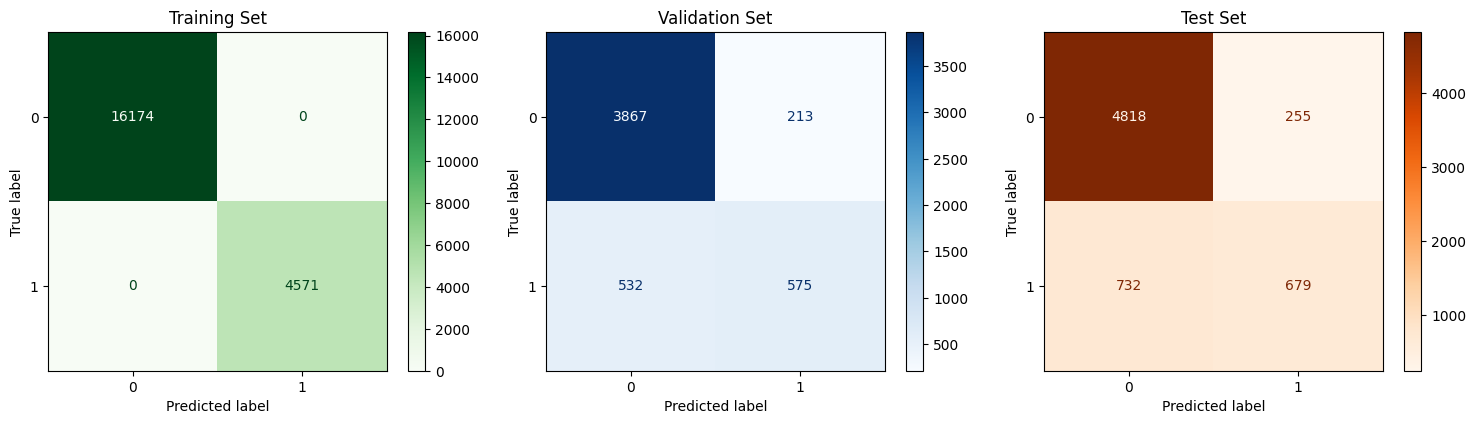

In [11]:
# --- Put metrics in a DataFrame for nice visualization ---
metrics_df = pd.DataFrame({
    "Train": [
        roc_auc_train, balanced_acc_train, precision_train, recall_train, 
        specificity_train, logloss_train, balanced_acc_manual_train
    ],

    "Validation": [
        roc_auc_valid, balanced_acc_valid, precision_valid, recall_valid, 
        specificity_valid, logloss_valid, balanced_acc_manual_valid
    ],
    "Test": [
        roc_auc_test, balanced_acc_test, precision_test, recall_test,
        specificity_test, logloss_test,  balanced_acc_manual_test
    ]
}, index=[
    "ROC AUC",
    "Balanced Accuracy",
    "Precision",
    "Recall (Sensitivity)",
    "Specificity",
    "Log Loss",
    "Balanced Accuracy"
])

# Round to 4 decimals for readability
metrics_df = metrics_df.round(4)

print("\n Model Performance Train, Validation and Test set:")
display(metrics_df)



# Create 1 row, 3 columns for subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))


# Training set confusion matrix
ConfusionMatrixDisplay.from_predictions(y_train, y_train, ax=axes[0], cmap="Greens") #instead of y_pred_valid i use y_train is it okay?
axes[0].set_title("Training Set")

# Validation set confusion matrix
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred_valid, ax=axes[1], cmap="Blues")
axes[1].set_title("Validation Set")

# Test set confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, ax=axes[2], cmap="Oranges")
axes[2].set_title("Test Set")



plt.tight_layout()
plt.show()


In [12]:
# --- Uncalibrated probabilities of the positive class from trained model for both validation and test sets ---
proba_raw_test = model.predict_proba(X_test)[:, 1]
proba_raw_valid = model.predict_proba(X_valid)[:, 1]

In [13]:
# --- PLATT calibration fits calibration models on validation set (model already trained) ---
platt = CalibratedClassifierCV(estimator=model, method="sigmoid", cv="prefit")
platt.fit(X_valid, y_valid)

CalibratedClassifierCV(cv='prefit', estimator=LogisticRegression(max_iter=1000))

In [58]:
#save the model 
joblib.dump(platt, "platt_calibrated_model.pkl")

['platt_calibrated_model.pkl']

In [14]:
# --- PLATT calibrated probabilities of the positive class from trained model for both validation and test sets ---
proba_platt_test = platt.predict_proba(X_test)[:, 1]
proba_platt_valid = platt.predict_proba(X_valid)[:, 1]

In [15]:
# --- ISOTONIC calibration fits calibration models on validation set (model already trained) ---
isotonic = CalibratedClassifierCV(estimator=model, method="isotonic", cv="prefit")
isotonic.fit(X_valid, y_valid)

CalibratedClassifierCV(cv='prefit', estimator=LogisticRegression(max_iter=1000),
                       method='isotonic')

In [59]:
#save the model 
joblib.dump(isotonic, "isotonic_calibrated_model.pkl")

['isotonic_calibrated_model.pkl']

In [16]:
# --- ISOTONIC calibrated probabilities of the positive class from trained model for both validation and test sets ---
proba_iso_test = isotonic.predict_proba(X_test)[:, 1]
proba_iso_valid = isotonic.predict_proba(X_valid)[:, 1]

In [17]:
# --- INDUCTIVE Ven Abers calibration fits calibration models on validation set (model already trained) ---

va_inductive = VennAbersCalibrator(estimator=model, inductive=True, cal_size=None, random_state=42)
va_inductive.fit(X_valid, y_valid)

p_cal = model.predict_proba(X_valid)
p_test = model.predict_proba(X_test)


VAC = VennAbersCalibrator()


In [60]:
#save the model
joblib.dump(va_inductive, "va_inductive.pkl")

['va_inductive.pkl']

In [ ]:
# --- Calibrated probabilities & intervals for the VALIDATION set ---
preds_val, intervals_val = VAC.predict_proba(
    p_cal=p_cal,
    y_cal=y_valid.values,
    p_test=p_cal,   # apply calibration to validation set itself
    p0_p1_output=True
)

# --- Calibrated probabilities & intervals for the TEST set ---
preds_test, intervals_test = VAC.predict_proba(
    p_cal=p_cal,
    y_cal=y_valid.values,
    p_test=p_test,
    p0_p1_output=True
)


# --- Extract positive class calibrated probabilities ---
proba_IVAP_valid = preds_val[:, 1]
proba_IVAP_test = preds_test[:, 1]


p1_IVAP_val=intervals_val[:, 1]
p0_IVAP_val=intervals_val[:, 0]

In [45]:
p1_IVAP_val=intervals_val[:, 1]
p0_IVAP_val=intervals_val[:, 0]

In [ ]:
p1_IVAP_test=intervals_test[:, 1]
p0_IVAP_test=intervals_test[:, 0]

In [19]:
# --- CROSS Ven Abers calibration fits calibration models on validation set (model already trained) ---

model1 = LogisticRegression(max_iter=100, solver="lbfgs")

va_cross = VennAbersCalibrator(
    estimator=model1,  
    inductive=False,
    n_splits=5,          
    random_state=42
)
va_cross.fit(X_combined, y_combined) #combine train and valid 

In [61]:
#save the model
joblib.dump(va_cross, "va_cross_calibrator.pkl")

['va_cross_calibrator.pkl']

In [62]:
#save the model
joblib.dump(model1, "LogisticRegression1.pkl")

['LogisticRegression1.pkl']

In [63]:
# --- CROSS calibrated probabilities of the positive class from trained model for both validation and test sets ---
predictions_cross_test, p_va_cross_p0_p1 = va_cross.predict_proba(X_test, p0_p1_output=True)
predictions_cross_valid, p_va_cross_val_p0_p1 = va_cross.predict_proba(X_valid, p0_p1_output=True)

proba_va_cross_test= predictions_cross_test[:, 1]
proba_va_cross_valid=predictions_cross_valid[:, 1]

In [ ]:
# Compute mean/min/max for p0/p1 of CROSS VA for val
p0s_val = p_va_cross_val_p0_p1[0][:, :5]
p1s_val = p_va_cross_val_p0_p1[0][:, 5:]

mean_p0_val = np.mean(p0s_val, axis=1)
mean_p1_val = np.mean(p1s_val, axis=1)
min_p0_val = np.min(p0s_val, axis=1)
max_p1_val = np.max(p1s_val, axis=1)

In [ ]:
# Compute mean/min/max for p0/p1 of CROSS VA for test
p0s_test = p_va_cross_p0_p1[0][:, :5]
p1s_test = p_va_cross_p0_p1[0][:, 5:]

mean_p0_test = np.mean(p0s_test, axis=1)
mean_p1_test = np.mean(p1s_test, axis=1)
min_p0_test = np.min(p0s_test, axis=1)
max_p1_test = np.max(p1s_test, axis=1)

In [ ]:
# --- Calibration metrics function (return metrics instead of only printing) ---
def calibration_metrics(y_true, y_proba, method_name):
    logloss = log_loss(y_true, y_proba)
    brier = brier_score_loss(y_true, y_proba)
    prob_true, prob_pred = calibration_curve(y_true, y_proba, n_bins=10)
    ece = np.abs(prob_true - prob_pred).mean()
    
    return {
        "Method": method_name,
        "Log Loss": logloss,
        "Brier Score": brier,
        "ECE": ece
    }

# --- Collect results into a list ---
results = []
results.append(calibration_metrics(y_test, proba_raw_test,   "Uncalibrated on test"))
results.append(calibration_metrics(y_test, proba_platt_test, "Platt Scaling on test"))
results.append(calibration_metrics(y_test, proba_iso_test,   "Isotonic Regression on test"))
results.append(calibration_metrics(y_test, proba_IVAP_test,       "Venn-Abers (Inductive) on test"))
results.append(calibration_metrics(y_test, proba_va_cross_test,     "Venn-Abers (Cross) on test"))


# --- Convert to DataFrame for comparison ---
calib_df = pd.DataFrame(results).set_index("Method").round(4)
print("\nCalibration Performance on test set:")
display(calib_df)


results1 = []
results1.append(calibration_metrics(y_valid, proba_raw_valid,   "Uncalibrated on valid"))
results1.append(calibration_metrics(y_valid, proba_platt_valid, "Platt Scaling  on valid"))
results1.append(calibration_metrics(y_valid, proba_iso_valid,   "Isotonic Regression  on valid"))
results1.append(calibration_metrics(y_valid, proba_IVAP_valid,       "Venn-Abers (Inductive)  on valid"))
results1.append(calibration_metrics(y_valid, proba_va_cross_valid,     "Venn-Abers (Cross)  on valid"))

# --- Convert to DataFrame for comparison ---
calib_df = pd.DataFrame(results1).set_index("Method").round(4)
print("\nCalibration Performance on valid set:")
display(calib_df)


Calibration Performance on test set:


,Log Loss,Brier Score,ECE
Method,,,
Uncalibrated on test,0.3570,0.1089,0.0291
Platt Scaling on test,0.3575,0.1088,0.0303
Isotonic Regression on test,0.3852,0.1090,0.0244
Venn-Abers (Inductive) on test,0.3559,0.1089,0.0291
Venn-Abers (Cross) on test,0.3542,0.1085,0.0157



Calibration Performance on valid set:


,Log Loss,Brier Score,ECE
Method,,,
Uncalibrated on valid,0.3445,0.1057,0.0292
Platt Scaling on valid,0.3442,0.1055,0.0260
Isotonic Regression on valid,0.3372,0.1036,0.0000
Venn-Abers (Inductive) on valid,0.3388,0.1038,0.0115
Venn-Abers (Cross) on valid,0.3426,0.1050,0.0235


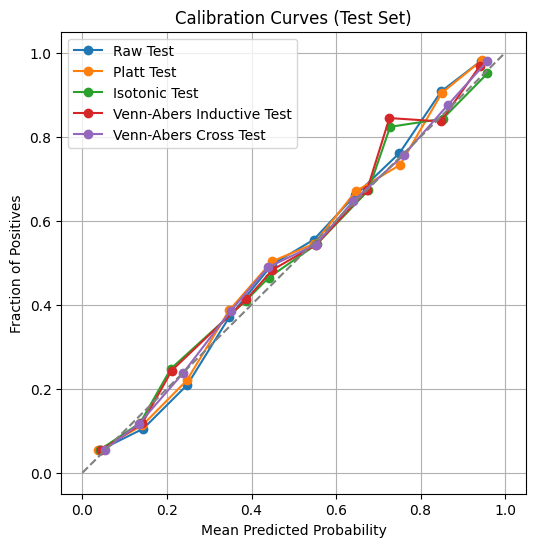

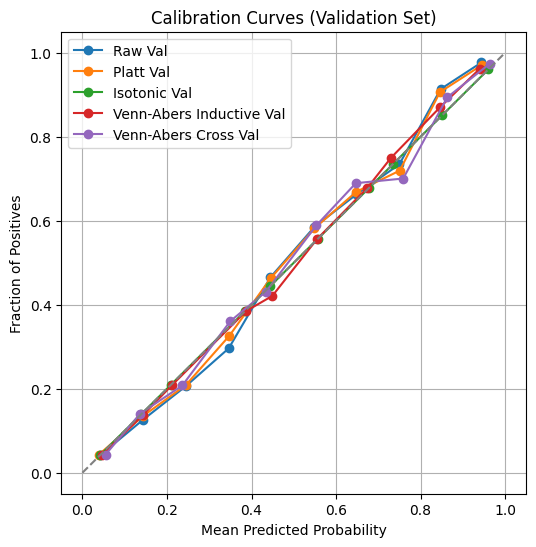

In [28]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# --- Figure for Test Set ---
plt.figure(figsize=(6, 6))
for proba, name in [
    (proba_raw_test, "Raw Test"),
    (proba_platt_test, "Platt Test"),
    (proba_iso_test, "Isotonic Test"),
    (proba_IVAP_test, "Venn-Abers Inductive Test"),
    (proba_va_cross_test, "Venn-Abers Cross Test"),
]:
    prob_true, prob_pred = calibration_curve(y_test, proba, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=name)

plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curves (Test Set)")
plt.legend()
plt.grid(True)
plt.show()


# --- Figure for Validation Set ---
plt.figure(figsize=(6, 6))
for proba, name in [
    (proba_raw_valid, "Raw Val"),
    (proba_platt_valid, "Platt Val"),
    (proba_iso_valid, "Isotonic Val"),
    (proba_IVAP_valid, "Venn-Abers Inductive Val"),
    (proba_va_cross_valid, "Venn-Abers Cross Val"),
]:
    prob_true, prob_pred = calibration_curve(y_valid, proba, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=name)

plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curves (Validation Set)")
plt.legend()
plt.grid(True)
plt.show()


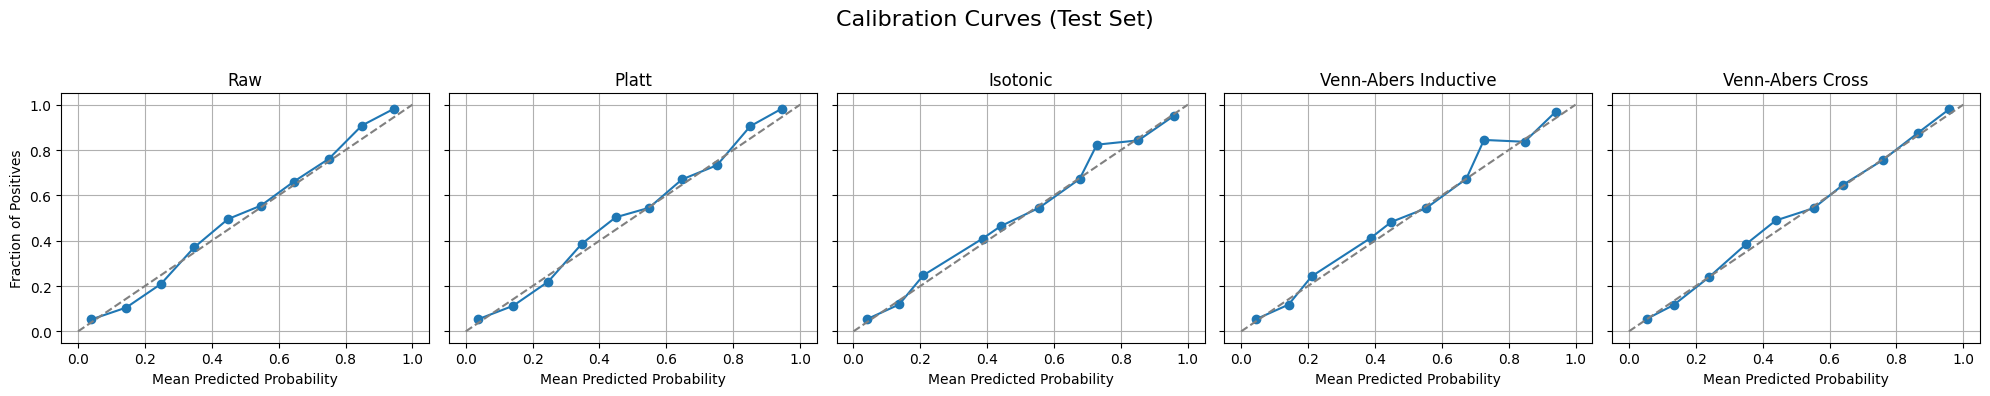

In [29]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# --- List of predictions and names ---
probas = [
    (proba_raw_test, "Raw"),
    (proba_platt_test, "Platt"),
    (proba_iso_test, "Isotonic"),
    (proba_IVAP_test, "Venn-Abers Inductive"),
    (proba_va_cross_test, "Venn-Abers Cross"),
]

# --- Create subplots side by side ---
fig, axes = plt.subplots(1, len(probas), figsize=(20, 4), sharey=True)

for ax, (proba, name) in zip(axes, probas):
    prob_true, prob_pred = calibration_curve(y_test, proba, n_bins=10)
    ax.plot(prob_pred, prob_true, marker='o', label=name)
    ax.plot([0, 1], [0, 1], '--', color='gray')
    ax.set_xlabel("Mean Predicted Probability")
    ax.set_title(name)
    ax.grid(True)

axes[0].set_ylabel("Fraction of Positives")
plt.suptitle("Calibration Curves (Test Set)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


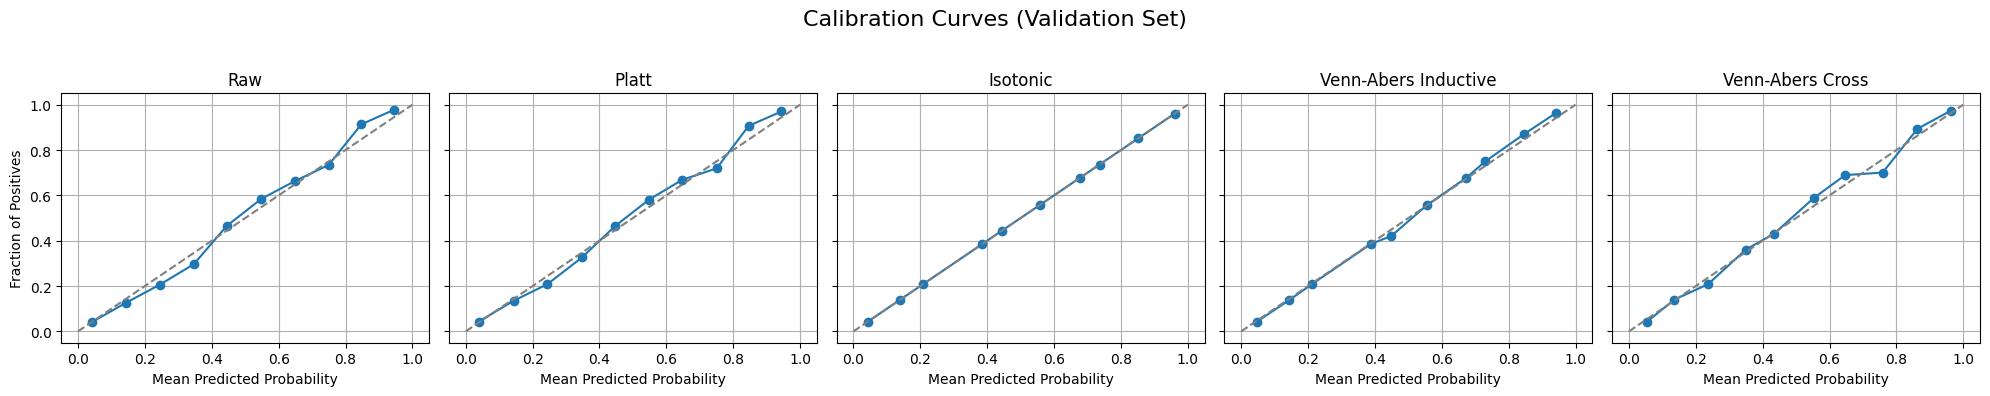

In [32]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# --- List of predictions and names ---
probas = [
    (proba_raw_valid, "Raw"),
    (proba_platt_valid, "Platt"),
    (proba_iso_valid, "Isotonic"),
    (proba_IVAP_valid, "Venn-Abers Inductive"),
    (proba_va_cross_valid, "Venn-Abers Cross"),
]

# --- Create subplots side by side ---
fig, axes = plt.subplots(1, len(probas), figsize=(20, 4), sharey=True)

for ax, (proba, name) in zip(axes, probas):
    prob_true, prob_pred = calibration_curve(y_valid, proba, n_bins=10)
    ax.plot(prob_pred, prob_true, marker='o', label=name)
    ax.plot([0, 1], [0, 1], '--', color='gray')
    ax.set_xlabel("Mean Predicted Probability")
    ax.set_title(name)
    ax.grid(True)

axes[0].set_ylabel("Fraction of Positives")
plt.suptitle("Calibration Curves (Validation Set)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [52]:
# --- Save all predictions and scores for final report TEST SET ---
df_output = pd.DataFrame({
    "ID": df_test["ID"],
    "loan_status": y_test,
    "raw_score": proba_raw_test,
    "platt_score": proba_platt_test,
    "isotonic_score": proba_iso_test,
    "venn_abers_ind_": proba_IVAP_test,
    "p0_va_ind" : p0_IVAP_test,
    "p1_va_ind" : p1_IVAP_test,
    "venn_abers_cross_score": proba_va_cross_test,
    "mean_p0_va_cross" : mean_p0_test,
    "mean_p1_va_cross" : mean_p1_test,
    "min_p0_va_cross" : min_p0_test,
    "max_p1_va_cross" : max_p1_test,

})

df_output.to_csv("/Users/elisaterzini/Desktop/Credit-Risk-Model-Calibration/DATA/test_predictions_and_calibration.csv", index=False)
print("Saved predictions to 'test_final_predictions_and_calibration.csv'")


Saved predictions to 'test_final_predictions_and_calibration.csv'


In [53]:
# --- Build DataFrame for validation set ---
df_output_val = pd.DataFrame({
    "ID": df_valid["ID"],       # replace with your validation IDs
    "loan_status": y_valid,
    "raw_score": proba_raw_valid,
    "platt_score": proba_platt_valid,
    "isotonic_score": proba_iso_valid,
    "venn_abers_ind_": proba_IVAP_valid,
    "p0_va_ind" : p0_IVAP_val,  # IVAP p0 for validation
    "p1_va_ind" : p1_IVAP_val,  # IVAP p1 for validation
    "venn_abers_cross_score": proba_va_cross_valid,
    "mean_p0_va_cross": mean_p0_val,
    "mean_p1_va_cross": mean_p1_val,
    "min_p0_va_cross": min_p0_val,
    "max_p1_va_cross": max_p1_val,
})

# Save to CSV
df_output_val.to_csv("/Users/elisaterzini/Desktop/Credit-Risk-Model-Calibration/DATA/validation_predictions_and_calibration.csv", index=False)
print("Saved validation predictions to 'validation_predictions_and_calibration.csv'")


Saved validation predictions to 'validation_predictions_and_calibration.csv'
